In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [87]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import matplotlib.colorizer as mcolorizer
import matplotlib.lines as mlines
import matplotlib.collections as mcolls

from mpl_toolkits.mplot3d import Axes3D, art3d

import cmocean

import homeomorphism_helpers as hh
from homeomorphism_helpers import fs

from papercolors import colordict as pcd

import numpy as np

In [6]:
verts = [[0, 0, -2 ],
         [-1, -1, -1], 
         [1, -1,  -1], 
         [1, 1,  -1 ], 
         [-1, 1, -1],
         [-1, -1, 1], 
         [1, -1, 1 ],
         [1, 1, 1], 
         [-1, 1, 1]]
V = .7 * np.array(verts) 
sides = {'TOP': [V[5], V[6], V[7], V[8]], 
         'F1': [V[1], V[2], V[6], V[5]], 
         'F2': [V[2], V[3], V[7], V[6]],
         'F3': [V[3], V[4], V[8], V[7]], 
         'F4': [V[4], V[1], V[5], V[8]], 
         'BOTTOM':[V[1], V[2], V[3], V[4]]}
cube_front = list(sides[s] for s in ['TOP', 'F1', 'F2'])

In [7]:
data = hh.get_data("nydata_2022.parquet")
df = data['df']
dates = data['dates']
lons = data['lons']
lats = data['lats']

nygeo, nyshp = hh.get_mapdata("nydata.csv", 's_22mr22.zip', hh.airports['map_date'])

[(-1.0, 1.0), (-1.0, 1.0), (-1.0, 1.0)]

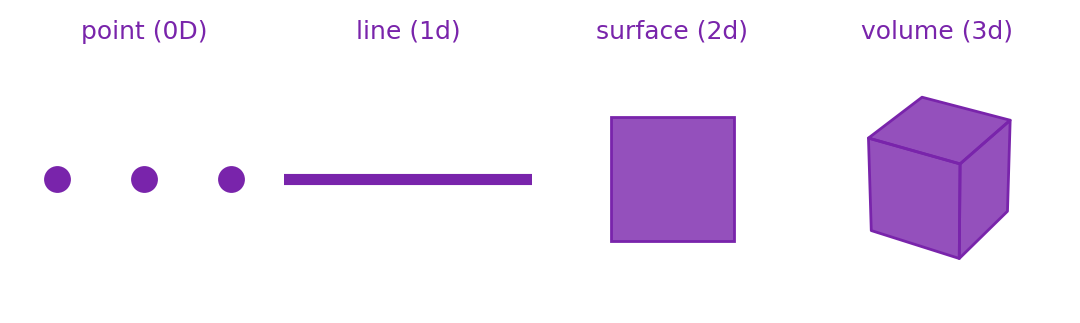

In [8]:
fig, axd = plt.subplot_mosaic([['dot', 'line', 'plane','cube']], 
                              figsize=(6, 1.5), layout='compressed', 
                              per_subplot_kw={'cube':{'projection':'3d'}})
for an in axd:
    axd[an].set(xlim=(0,1), ylim=(0,1), aspect='equal', xticklabels=[], yticklabels=[])
    axd[an].axis('off')
dot = axd['dot'].scatter([.15, .5, .85], [.5]*3, color=pcd['base'], s=75) 
axd['dot'].set_title("point (0D)", color=pcd['base'], size=fs['small'])
line = axd['line'].axhline(.5, color=pcd['base'], lw=4)
axd['line'].set_title("line (1d)", color=pcd['base'], size=fs['small'])

alpha =  .8
plane = mpatches.Rectangle((.25, .25), .5, .5, facecolor=(pcd['base'], alpha), edgecolor=pcd['base'])
axd['plane'].add_artist(plane)
axd['plane'].set_title('surface (2d)', color=pcd['base'], size=fs['small'])
axd['cube'].set_title('volume (3d)', color=pcd['base'], size=fs['small'])


collection = art3d.Poly3DCollection(cube_front, closed=True, edgecolor=pcd['base'], facecolor=(pcd['base'], alpha))
axd['cube'].add_collection(collection)
axd['cube'].set_aspect('equalxy')
axd['cube'].set(xlim=(-1,1), ylim=(-1, 1), zlim=(-1, 1))


In [14]:
def plot_stations(ax, fontsize=fs['normal']):
    ax.text(.5, .5, "{JFK, LGA, ALB}",  fontsize=fontsize, va='center', ha='center', color=pcd['section'])
    ax.axis('off')


def plot_time(ax, df, year=True, interval=1, labelsize=fs['small']):
    ax.spines.bottom.set_position(('data', 0.5))
    ax.set(ylim=(0,1), yticks=[])
    ax.spines[:].set_color(pcd['section'])
    ax.spines[['top', 'right', 'left']].set_visible(False)
    ts = hh.get_timeseries(df, hh.airports['t_lat'], hh.airports['t_lon'])
    ln,  = ax.plot('DATE_DTYPE', "PRCP", data=ts, color = 'none')
    ax.set_xlim(xmin=ts['DATE_DTYPE'].min(), xmax=ts['DATE_DTYPE'].max())
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=interval))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    #axd['time'].xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax.tick_params(labelsize=labelsize, color=pcd['section'], labelcolor=pcd['section'])
    ax.tick_params(which='minor', color=pcd['section'], labelcolor=pcd['section'])
    if year:
        ax.annotate(ts['DATE_DTYPE'][0].dt.year.values[0], (1, .4), xycoords='axes fraction', 
                    fontsize=fs['small']-1, va='top', ha='center', color=pcd['section'])


def plot_var(ax, fig):
    norm = mcolors.Normalize(vmin=0, vmax=1)
    cmap = cmocean.cm.rain
    cmap = mcolors.ListedColormap(pcd['section'])
    colorizer = mcolorizer.Colorizer(norm=norm, cmap=cmap)
    sm = mcolorizer.ColorizingArtist(colorizer)
    cax = ax.inset_axes([0, .4, 1, .2])
    cb = fig.colorbar(sm, cax=cax, extend='max', orientation='horizontal')
    cb.ax.tick_params(labelsize=fs['script'], length=5, pad=2, color=pcd['section'], labelcolor=pcd['section'])
    cb.ax.xaxis.set_major_formatter("{:0.1f} in.".format)
    cb.outline.set_color(pcd['section'])
    ax.axis('off')

def plot_loc(ax, nyshp, nygeo):
    mp = nyshp.plot(ax=ax,  facecolor=(pcd['section'], .25), edgecolor=pcd['section'])
    
    for p_id in [('JFK INTL AP'), ('LAGUARDIA AP'), ('ALBANY INTL AP')]:
        nygeo[nygeo['NAME']==p_id].plot(marker ='x',color=pcd['section'], ax=ax, markersize=60, lw=2)
    
    ax.grid(ls=':', color=pcd['section'])
    ax.spines[:].set_color(pcd['section'])
    ax.tick_params(color=pcd['section'], labelcolor=pcd['section'], labelsize=fs['script'], length=2)

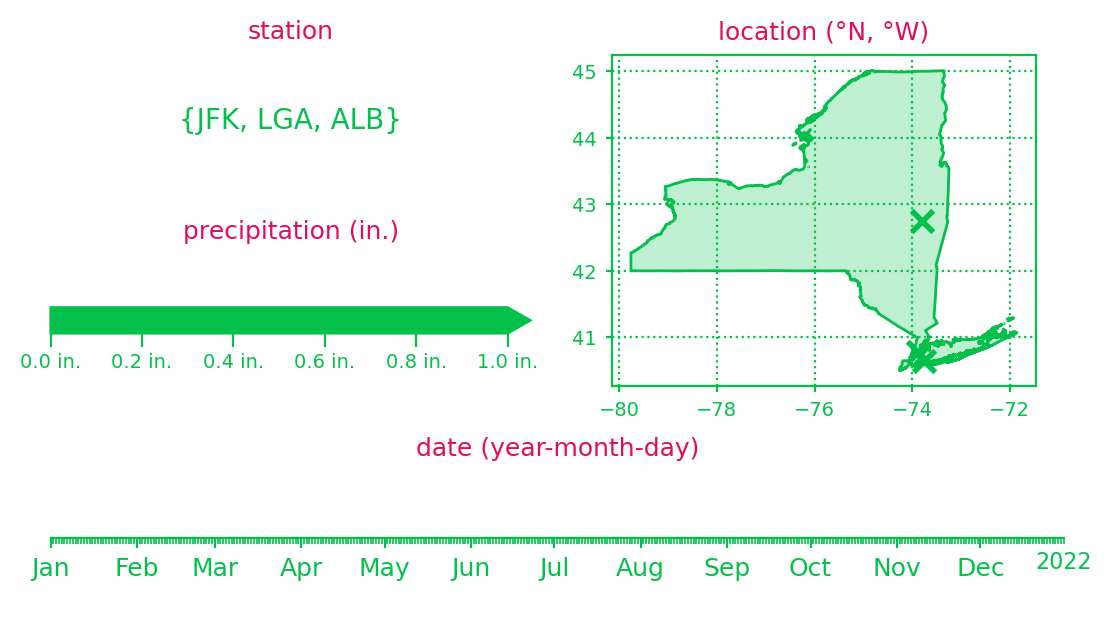

In [15]:
fig, axd = plt.subplot_mosaic([['stations', 'loc'], ['var', 'loc'], ['time', 'time']],
                              figsize=(6, 3), layout='compressed')
#{JFK, LGA, ALB}

axd['stations'].set_title("station",  color=pcd['fiber'], size=fs['small'])
axd['time'].set_title("date (year-month-day)", color=pcd['fiber'], size=fs['small'])
axd['var'].set_title("precipitation (in.)", color=pcd['fiber'], size=fs['small'])
axd['loc'].set_title("location (°N, °W)",  color=pcd['fiber'], size=fs['small'])

plot_stations(axd['stations'])
plot_time(axd['time'], df)
plot_var(axd['var'], fig)

plot_loc(axd['loc'], nyshp, nygeo)

[np.float64(0.6102350000000001), np.float64(0.578739), np.float64(0.29133800000000004)]


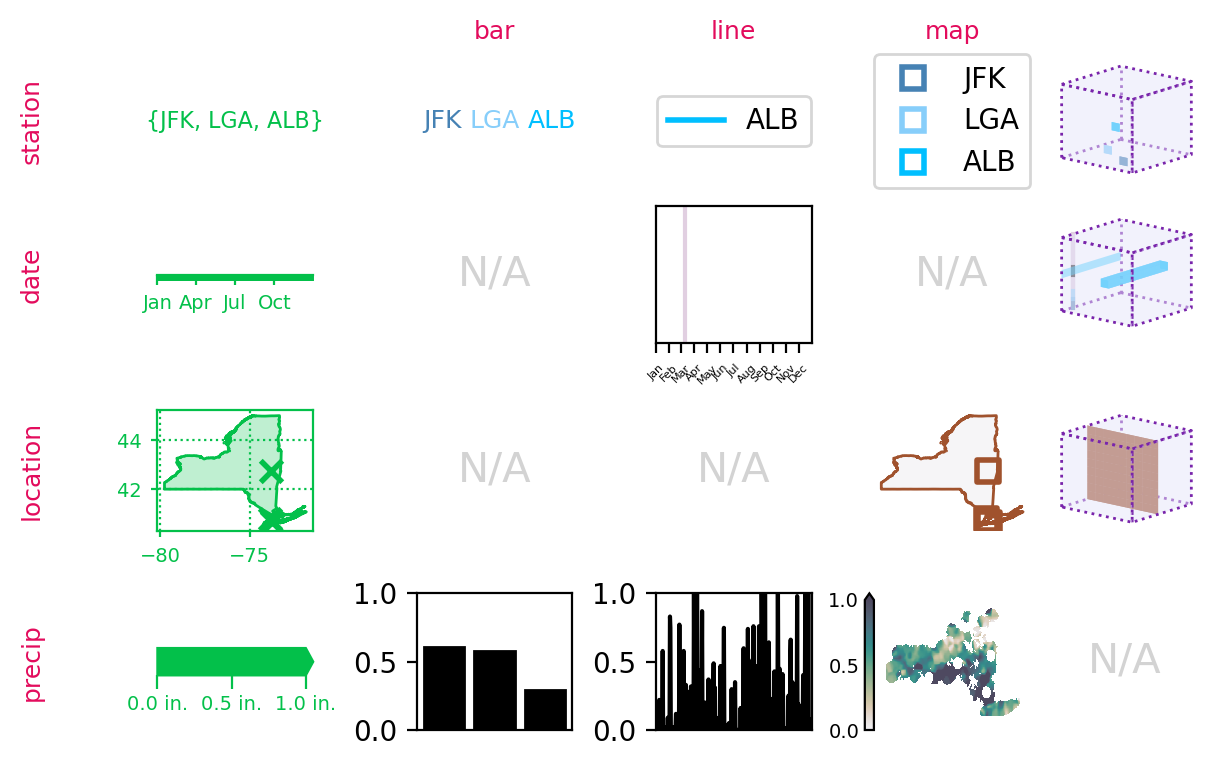

In [109]:
fig, axes = plt.subplots(4,5, figsize=(6,4), layout='compressed')

    
plot_stations(axes[0,0], fontsize=fs['normal']-2)
plot_time(axes[1,0], df, year=False, interval=3, labelsize=fs['small']-2)
plot_loc(axes[2,0], nyshp, nygeo)
plot_var(axes[3,0], fig)

for i, label in enumerate(['station', 'date', 'location', 'precip']):
    axes[i,0].annotate(label, xy=(0.025,.5), xycoords=(fig.transFigure, axes[i,0].transAxes), 
                       color=pcd['fiber'], size=fs['small'], rotation=90, va='center', ha='right')

for i, label in enumerate(['bar', 'line', 'map', 'index']):
    axes[0, i+1].annotate(label, xy=(.5, .925), xycoords=(axes[0,i+1].transAxes, fig.transFigure), 
                       color=pcd['fiber'], size=fs['small'], va='bottom', ha='center', zorder=10)

# stations
# position + color, axes[0,1]

st_str = [('JFK', hh.airports['jfk_color']), (' ', 'k'), 
          ('LGA', hh.airports['lga_color']), (' ', 'k'), ('ALB', hh.airports['time_color'])]

#center text
t = axes[0,1].text(.5, .5, st_str[2][0], color=st_str[2][1], 
                    fontsize=fs['normal']-1, va='center', ha='center')
# right text
tr = t
for s, c in st_str[3:]:
    tr = axes[0,1].annotate(s, xy=(1,0), xycoords=tr, color=c,  
                           fontsize=fs['normal']-1, va='bottom', ha='left')
#left text
tl = t
for s, c in st_str[:2][::-1]:
    tl = axes[0,1].annotate(s, xy=(0,0), xycoords=tl, color=c, 
                                  fontsize=fs['normal']-1, va='bottom', ha='right')
axes[0,1].axis('off')

# marker

custom_lines = [mlines.Line2D([0], [0], color= hh.airports['time_color'], lw=2)]
axes[0,2].legend(custom_lines, ["ALB"], loc='center')
axes[0,2].axis('off')

# marker + marker color
handles_labels = [ (mlines.Line2D([0], [0], marker ='s', color='none', 
                                  markeredgecolor=c, markerfacecolor='none', markersize=8, markeredgewidth=2), s)
                                          for s, c in st_str[::2]]
axes[0,3].legend(*list(zip(*handles_labels)), loc='center',)
axes[0,3].axis('off')

# square
axes[0,4].remove()
axc = fig.add_subplot(4, 5, 5, projection='3d')
hh.make_cube(dates, lons, lats, axc, labels=False, dims=0)
axc.set_box_aspect(None, zoom=1.2)
axc.set_proj_type('ortho')
axes[0,4] = axc

# date

# x axis
ln = hh.make_ts(df, axes[1,2], year=False)
ln.set_visible(False)
axes[1,2].tick_params(labelsize=fs['tiny']-1, rotation=45)
axes[1,2].set_yticks([])

#index
axes[1,4].remove()
axc = fig.add_subplot(4, 5, 10, projection='3d')
hh.make_cube(dates, lons, lats, axc, labels=False, dims=1)
axc.set_box_aspect(None, zoom=1.2)
axc.set_proj_type('ortho')
axes[1,4] = axc

#map

mp, im = hh.make_map(nygeo, nyshp, axes[2,3], colorbar=False, square=True, label=False)
A = im.get_array()
A[:,:] = np.nan
im.set_array(A)
[m.set_edgecolor(hh.airports['map_color']) 
 for m in mp.get_children() if isinstance(m, mcolls.PathCollection) ]



# index
axes[2,4].remove()
axc = fig.add_subplot(4, 5, 15, projection='3d')
hh.make_cube(dates, lons, lats, axc, labels=False, dims=2)
axc.set_box_aspect(None, zoom=1.2)
axc.set_proj_type('ortho')
axes[2,4] = axc


# precip 

ecolor='k'

# encoded as height
bars = hh.make_bars(df, axes[3,1])
[b.set_color(ecolor) for b in bars]
axes[3,1].set(xticks=[], title=None, ylim=(0,1))

# encoded as line
ln = hh.make_ts(df, axes[3,2], year=False, day=False)
ln.set_color(ecolor)
axes[3,2].set(xticks=[], ylim=(0,1))


# encoded as color
mp, im = hh.make_map(nygeo, nyshp, axes[3,3], colorbar=True, square=False, label=False)
mp.get_children()[0].set_facecolor('none')
mp.get_children()[2].set_edgecolor('none')

#not applicable
for i, j in[(1,1), (2,1), (1, 3), (2, 2), (3, 4)]:
    axes[i,j].text(.5, .5, "N/A", color='lightgray', ha='center', va='center', 
                   transform=axes[i,j].transAxes, size = fs['heading']+3)
    axes[i,j].axis('off')


